In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_boston = pd.read_csv('D:/BostonHousing.csv')

In [3]:
df_boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
y = df_boston['medv'].values
X = df_boston.drop(columns = ['medv']).values

In [5]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

ШАП

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
model = XGBRegressor(objective='reg:squarederror', random_state=4)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
y_pred = model.predict(X_test)

In [21]:
X_test

array([[9.17800e-02, 0.00000e+00, 4.05000e+00, ..., 1.66000e+01,
        3.95500e+02, 9.04000e+00],
       [5.64400e-02, 4.00000e+01, 6.41000e+00, ..., 1.76000e+01,
        3.96900e+02, 3.53000e+00],
       [1.05740e-01, 0.00000e+00, 2.77400e+01, ..., 2.01000e+01,
        3.90110e+02, 1.80700e+01],
       ...,
       [1.40507e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.50500e+01, 2.12200e+01],
       [5.18800e-02, 0.00000e+00, 4.49000e+00, ..., 1.85000e+01,
        3.95990e+02, 1.28600e+01],
       [9.51200e-02, 0.00000e+00, 1.28300e+01, ..., 1.87000e+01,
        3.83230e+02, 8.94000e+00]])

In [20]:
y_pred[0]

24.276764

In [59]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

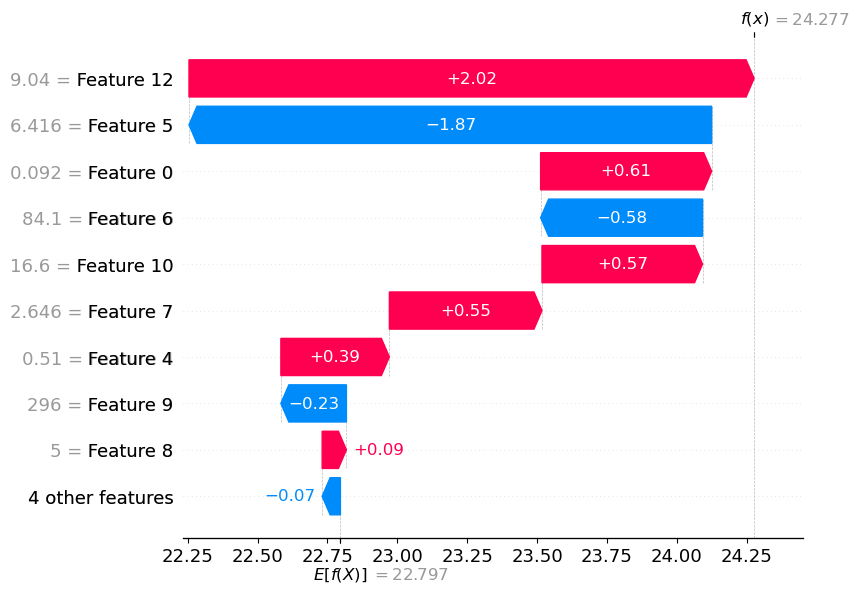

In [19]:
shap.plots.waterfall(shap_values[0])

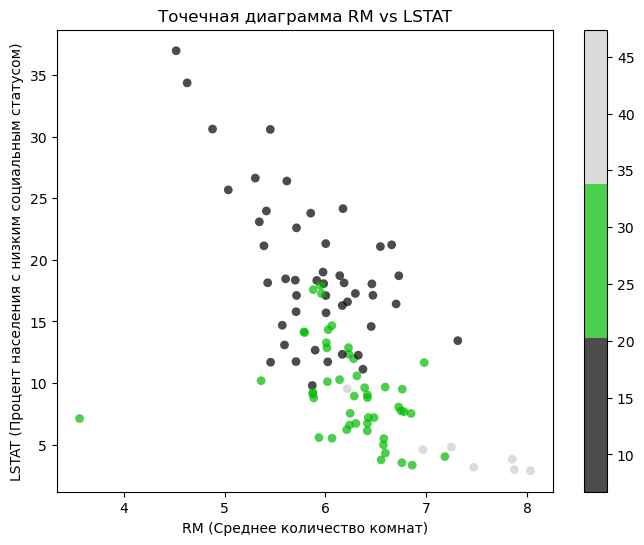

In [43]:
feature_x = X_test[:, 5]
feature_y = X_test[:, 12]
price =  y_pred

# Создание точечной диаграммы
plt.figure(figsize=(8,6))
plt.scatter(feature_x, feature_y, c=price, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.xlabel("RM (Среднее количество комнат)")
plt.ylabel("LSTAT (Процент населения с низким социальным статусом)")
plt.title("Точечная диаграмма RM vs LSTAT")
plt.show()

Уменьшение размерности

In [6]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42)

In [7]:
# Инициализация PCA с 2 компонентами
pca = PCA(n_components=2)

# Применение PCA
X_transformed = pca.fit_transform(X_trains)

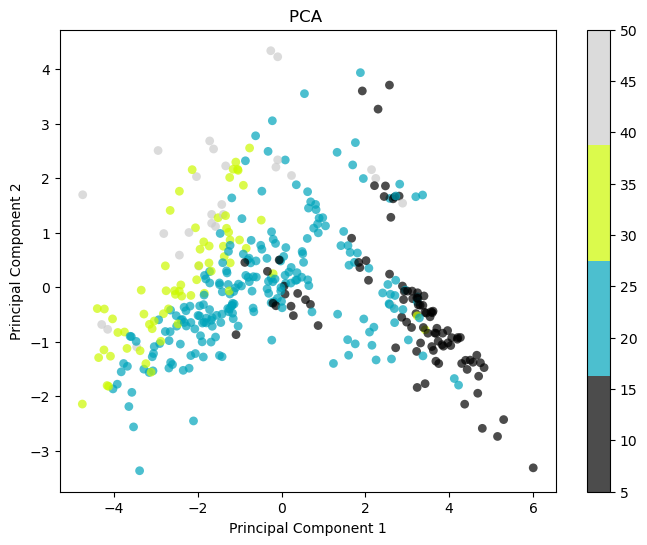

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_trains, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.colorbar()
plt.title('PCA ')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Инфляция дисперсии 

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [45]:
X = add_constant(df_boston.drop('medv', axis=1))

In [46]:
# расчет VIF для каждого предиктора
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

   Variable         VIF
0     const  585.265238
1      crim    1.792192
2        zn    2.298758
3     indus    3.991596
4      chas    1.073995
5       nox    4.393720
6        rm    1.933744
7       age    3.100826
8       dis    3.955945
9       rad    7.484496
10      tax    9.008554
11  ptratio    1.799084
12        b    1.348521
13    lstat    2.941491


In [56]:
high_vif = VIFs[VIFs['VIF'] > 5]  
data = X.drop(columns=high_vif['Variable'])

In [47]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=3)
pls.fit(X, y)

PLSRegression(n_components=3)

In [48]:
from sklearn.linear_model import Lasso, Ridge

# LASSO регрессия
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
print("LASSO Coefficients:", lasso.coef_)

# Ridge регрессия
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
print("Ridge Coefficients:", ridge.coef_)

LASSO Coefficients: [ 0.         -0.09789363  0.04921111 -0.03661906  0.95519003 -0.
  3.70320175 -0.01003698 -1.16053834  0.27470721 -0.01457017 -0.77065434
  0.01024917 -0.56876914]
Ridge Coefficients: [ 0.00000000e+00 -1.04595278e-01  4.74432243e-02 -8.80467889e-03
  2.55239322e+00 -1.07770146e+01  3.85400020e+00 -5.41453810e-03
 -1.37265353e+00  2.90141589e-01 -1.29116463e-02 -8.76074394e-01
  9.67327945e-03 -5.33343225e-01]


Вывод: 
Сначала проводится инфляция дисперсии, чтобы сразу отсеять фичи, которые сильно коррелируют между собой. Потом проводим уменьшение размерности и обучаем модель. И в конце с помощью Шапа смотрим, какие фичи больше всего повлияли на результат